In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import nibabel as nib
import numpy as np


In [20]:

csv_fn = "/Volumes/bai/NACC/investigator_nacc71.csv"
df = pd.read_csv(csv_fn)
print(df.head())
len(df)

       NACCID  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  NACCVNUM  \
0  NACC002909      186      I      3.0       12        28     2022         1   
1  NACC002909      186      F      3.0        1        23     2024         2   
2  NACC002909      186      F      3.0        3         5     2025         3   
3  NACC003142      186      I      3.0        2        11     2025         1   
4  NACC003487      186      I      3.0       11        15     2023         1   

   NACCAVST  NACCNVST  ...  NPATGAM1  NPATGAM2  NPATGAM3  NPATGAM4  NPATGAM5  \
0         3         3  ...      -4.0      -4.0      -4.0      -4.0      -4.0   
1         3         3  ...      -4.0      -4.0      -4.0      -4.0      -4.0   
2         3         3  ...      -4.0      -4.0      -4.0      -4.0      -4.0   
3         1         1  ...      -4.0      -4.0      -4.0      -4.0      -4.0   
4         2         2  ...      -4.0      -4.0      -4.0      -4.0      -4.0   

   NPATGFRN  NPATGFR1  NPATGFR2  NPATG

/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_54116/4232704962.py:2: DtypeWarning: Columns (46,99,100,101,102,397,454,638,951) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_fn)


812

In [21]:
# Get visit information for a subject
def nacc_case_timeline(df, naccid,
                       id_col="NACCID",
                       year_col="VISITYR",
                       month_col="VISITMO",
                       day_col="VISITDAY",
                       visitnum_col="NACCVNUM"):
    """
    Return all visits for one NACCID as a time-ordered timeline.

    Parameters
    ----------
    df : pd.DataFrame
        NACC clinical table (one row per visit).
    naccid : int or str
        The NACCID of interest.
    id_col, year_col, month_col, day_col, visitnum_col : str
        Column names in df.

    Returns
    -------
    timeline : pd.DataFrame
        Subset of df for this NACCID, with:
        - 'visit_date' (datetime64)
        - sorted by visit_date then visit number.
    """

    # Filter to this subject
    sub = df[df[id_col] == naccid].copy()

    if sub.empty:
        raise ValueError(f"No rows found for {id_col}={naccid}")

    # Build a proper datetime column
    sub["visit_date"] = pd.to_datetime(
        dict(
            year=sub[year_col],
            month=sub[month_col],
            day=sub[day_col]
        ),
        errors="coerce"  # invalid/missing dates become NaT
    )

    # Sort chronologically (then by visit number as tiebreaker)
    sort_cols = []
    if "visit_date" in sub.columns:
        sort_cols.append("visit_date")
    if visitnum_col in sub.columns:
        sort_cols.append(visitnum_col)

    sub = sub.sort_values(sort_cols).reset_index(drop=True)

    return sub


In [22]:
example_naccid = df["NACCID"].iloc[0]
timeline = nacc_case_timeline(df, naccid=example_naccid)

print(timeline[["NACCID", "NACCVNUM", "visit_date"]].head())

       NACCID  NACCVNUM visit_date
0  NACC002909         1 2022-12-28
1  NACC002909         2 2024-01-23
2  NACC002909         3 2025-03-05


In [15]:
data_dir = "/Volumes/bai/NACC/MRI/all/nifti/"
# check howmany files are in the directory
nifti_files = [f for f in os.listdir(data_dir) if f.endswith('.nii') or f.endswith('.nii.gz')or f.endswith('.zip')]
print(f"Found {len(nifti_files)} NIfTI (zip) files.")

Found 6498 NIfTI (zip) files.


In [5]:
mri_img_fn = "/Volumes/bai/NACC/MRI/all/nifti/943_NACC154191_20200228ni.zip"

with zipfile.ZipFile(mri_img_fn, 'r') as z:
    print(z.namelist())

['943_NACC154191_20200228/', '943_NACC154191_20200228/t1sag_208_3_128401136192408473843014414135288321582809643317/', '943_NACC154191_20200228/t2flairsag_92_12_128401136192408473843014414135288321582809643335/', '943_NACC154191_20200228/t2flairsag_92_12_128401136192408473843014414135288321582809643335/1.2.840.113619.2.408.4738430.14414135.28832.1582809643.335.nii', '943_NACC154191_20200228/t2flairsag_92_12_128401136192408473843014414135288321582809643335/1.2.840.113619.2.408.4738430.14414135.28832.1582809643.335.json', '943_NACC154191_20200228/t1sag_208_3_128401136192408473843014414135288321582809643317/1.2.840.113619.2.408.4738430.14414135.28832.1582809643.317.nii', '943_NACC154191_20200228/t1sag_208_3_128401136192408473843014414135288321582809643317/1.2.840.113619.2.408.4738430.14414135.28832.1582809643.317.json']


In [ ]:
def load_nacc_mri_from_zip(zip_path, extract_to="tmp_extract"):
    import zipfile, nibabel as nib
    from pathlib import Path

    extract_dir = Path(extract_to)
    extract_dir.mkdir(exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as z:
        nii_files = [f for f in z.namelist() if f.endswith((".nii", ".nii.gz"))]
        if len(nii_files) == 0:
            raise ValueError("No NIfTI files found inside zip.")
        z.extract(nii_files[0], path=extract_dir)

    nii_path = extract_dir / nii_files[0]
    return nib.load(str(nii_path))

img = load_nacc_mri_from_zip(mri_img_fn)


In [10]:
data = img.get_fdata()
print("Shape:", data.shape)

# Get affine (spatial transform)
affine = img.affine
print("Affine:\n", affine)

Shape: (256, 256, 92)
Affine:
 [[   0.       0.       2.     -91.   ]
 [  -1.       0.      -0.     139.375]
 [   0.       1.       0.    -147.5  ]
 [   0.       0.       0.       1.   ]]


In [13]:
# Get header metadata
header = img.header
print("Voxel sizes:", header.get_zooms())
print("==========================")
print(header)

Voxel sizes: (np.float32(1.0), np.float32(1.0), np.float32(2.0))
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3 256 256  92   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.     1.     1.     2.     6.002  0.     0.     0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'TE=1.5e+02;Time=144113.000')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_

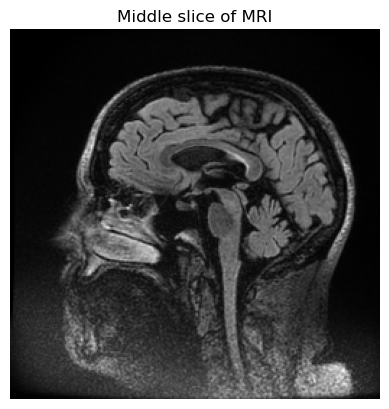

In [14]:
img_slice = data[:, :, data.shape[2] // 2]
plt.imshow(img_slice.T, cmap="gray", origin="lower")
plt.title("Middle slice of MRI")
plt.axis("off")
plt.show()